In [6]:
# from pytorch_lightning.loggers.base import LightningLoggerBase#()
# LightningLoggerBase()

In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression

import pytorch_lightning as pl
import torch
from pytorch_lightning import LightningModule, Trainer, seed_everything
from torch import Tensor, nn
from torch.nn import functional as F
from torch.nn.functional import softmax, pairwise_distance
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torchmetrics.functional import accuracy

from pl_bolts.datamodules import SklearnDataModule

from argparse import ArgumentParser
from typing import Any, Dict, List, Tuple, Type
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

def rescale(xx):
    return(xx/xx.sum(axis=1)[:, np.newaxis] )

class PL_DEBIASM_unib(pl.LightningModule):
    """Logistic regression model."""

    def __init__(
        self,
#         X, 
#         batch_sim_strength: float,
        input_dim: int,
        num_classes: int,
        bias: bool = True,
        learning_rate: float = 1e-4,
        optimizer: Type[Optimizer] = Adam,
        l1_strength: float = 0.0,
        l2_strength: float = 0.0,
        w_l2 : float = 0.0,
        use_log: bool=False,
        **kwargs: Any,
    ) -> None:
        """
        Args:
            input_dim: number of dimensions of the input (at least 1)
            num_classes: number of class labels (binary: 2, multi-class: >2)
            bias: specifies if a constant or intercept should be fitted (equivalent to fit_intercept in sklearn)
            learning_rate: learning_rate for the optimizer
            optimizer: the optimizer to use (default: ``Adam``)
            l1_strength: L1 regularization strength (default: ``0.0``)
            l2_strength: L2 regularization strength (default: ``0.0``)
        """
        super().__init__()
        self.save_hyperparameters()
        self.optimizer = optimizer
        
        
        self.linear = nn.Linear(in_features=self.hparams.input_dim, 
                                out_features=self.hparams.num_classes, 
                                bias=bias)

#         self.X=X
        self.batch_weights = torch.nn.Parameter(data = torch.zeros(1,input_dim))
        
        
    def forward(self, x: Tensor) -> Tensor:
        x = F.normalize( torch.pow(2, self.batch_weights ) * x, p=1 )
        x = self.linear(x)
        y_hat = softmax(x)
        return y_hat

    
    def training_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Dict[str, Tensor]:
        x, y = batch
        
        # flatten any input
        x = x.view(x.size(0), -1)
        y_hat = self.forward(x)
        
        # PyTorch cross_entropy function combines log_softmax and nll_loss in single function
        loss = F.cross_entropy(y_hat, y, reduction="sum")
        
        # L1 regularizer
        if self.hparams.l1_strength > 0:
            l1_reg = self.linear.weight.abs().sum()
            loss += self.hparams.l1_strength * l1_reg

        # L2 regularizer
        if self.hparams.l2_strength > 0:
            l2_reg = self.linear.weight.pow(2).sum()
            loss += self.hparams.l2_strength * l2_reg
        
            
        # L2 regularizer for bias weight    
        if self.hparams.w_l2 > 0:
            # L2 regularizer for weighting parameter
            l2_reg = self.batch_weights.pow(2).sum()
            loss += self.hparams.w_l2 * l2_reg



        loss /= float( x.size(0) )
        return {"loss": loss}

    def validation_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Dict[str, Tensor]:
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.forward(x)
        
         # PyTorch cross_entropy function combines log_softmax and nll_loss in single function
        loss = F.cross_entropy(y_hat, y, reduction="sum")
        
        # L1 regularizer
        if self.hparams.l1_strength > 0:
            l1_reg = self.linear.weight.abs().sum()
            loss += self.hparams.l1_strength * l1_reg

        # L2 regularizer
        if self.hparams.l2_strength > 0:
            l2_reg = self.linear.weight.pow(2).sum()
            loss += self.hparams.l2_strength * l2_reg
        
        self.log('val_loss', loss)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs: List[Dict[str, Tensor]]) -> Dict[str, Tensor]:
        acc = 0
        val_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        
        return {"val_loss": val_loss}

    def test_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Dict[str, Tensor]:
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.forward(x)
        acc = 0#
        return {"test_loss": F.cross_entropy(y_hat, y),
                "acc": acc}

    def test_epoch_end(self, outputs: List[Dict[str, Tensor]]) -> Dict[str, Tensor]:
        acc = 0
        test_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        tensorboard_logs = {"test_ce_loss": test_loss, "test_acc": acc}
        progress_bar_metrics = tensorboard_logs
        return {"test_loss": test_loss,
                "log": tensorboard_logs,
                "progress_bar": progress_bar_metrics}

    def configure_optimizers(self) -> Optimizer:
        return self.optimizer(self.parameters(), lr=self.hparams.learning_rate)

    @staticmethod
    def add_model_specific_args(parent_parser: ArgumentParser) -> ArgumentParser:
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--learning_rate", type=float, default=0.0001)
        parser.add_argument("--input_dim", type=int, default=None)
        parser.add_argument("--num_classes", type=int, default=None)
        parser.add_argument("--bias", default="store_true")
        parser.add_argument("--batch_size", type=int, default=100)
        
        return parser
    
    
    
    
def DEBIASM_unib_train_and_pred(X_train, 
                         X_val, 
                         y_train, 
                         y_val,
                         w_l2 = 0,
                         batch_size=None,
                         learning_rate=0.005,
                         l2_strength=0,
                         includes_batches=False,
                         val_split=0.1, 
                         test_split=0,
                         min_epochs=15, 
#                          use_log=False, 
                         verbose=False
                         ):
    
    if batch_size is None:
        batch_size=X_train.shape[0]
    
    baseline_mod = LogisticRegression(max_iter=2500)
    baseline_mod.fit(rescale( X_train ), y_train)
        
        
    model = PL_DEBIASM_unib( # X = torch.tensor( X_train),
#                       batch_sim_strength = batch_sim_strength,
                      input_dim = X_train.shape[1], 
                      num_classes = 2, 
                      batch_size = batch_size,
                      learning_rate = learning_rate,
                      l2_strength = l2_strength, 
                      w_l2 = w_l2
                       )
    
    ## initialize parameters to lbe similar to standard logistic regression
    model.linear.weight.data[0]=-torch.tensor( baseline_mod.coef_[0] )
    model.linear.weight.data[1]= torch.tensor( baseline_mod.coef_[0] )

    ## build pl dataloader
    dm = SklearnDataModule(X_train, 
                           y_train.astype(int),
                           val_split=val_split,
                           test_split=test_split
                           )

    ## run training
    trainer = pl.Trainer(logger=False, 
                         checkpoint_callback=False,
                         callbacks=[EarlyStopping(monitor="val_loss",
                                                  mode="min",
                                                  patience=2)
                                   ], 
                             check_val_every_n_epoch=2, 
                             weights_summary=None, 
                             progress_bar_refresh_rate=0,#verbose, 
                             min_epochs=min_epochs
                            )
    trainer.fit(model, 
                train_dataloaders=dm.train_dataloader(), 
                val_dataloaders=dm.val_dataloader()
               )
    
    ## get val predictions
    val_preds = model.forward( torch.tensor( X_val ).float() 
                                    )[:, 1].detach().numpy()
    
    ## return predictions and the model
    return( val_preds, model )

In [67]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn.functional import pairwise_distance
from sklearn.base import BaseEstimator
# from .torch_functions import DEBIASM_train_and_pred, DEBIASM_train_and_pred_log_additive

class DebiasMunibClassifier(BaseEstimator):
    """DebiasMClassifier: an sklean-style wrapper for the DEBIAS-M torch implementation."""
    def __init__(self,
                 *, 
                 learning_rate=0.005, 
                 min_epochs=25,
                 l2_strength=0,
                 w_l2=0,
                 random_state=None,
#                  x_val=0
                 ):
        
        self.learning_rate=learning_rate
        self.min_epochs=min_epochs
        self.l2_strength=l2_strength
        self.w_l2=w_l2
#         self.x_val = x_val
        self.random_state=random_state
        
    def fit(self, X, y, sample_weight=None):
        """Fit the baseline classifier.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        
        self.classes_ = np.unique(y)
        preds, mod = DEBIASM_unib_train_and_pred(
                                            X, 
                                            0,#self.x_val, 
                                            y, 
                                            0,
#                                             batch_sim_strength = self.batch_str,
                                            learning_rate=self.learning_rate,
                                            min_epochs= self.min_epochs,
                                            l2_strength=self.l2_strength,
                                            w_l2 = self.w_l2
                                            )
        self.model = mod
        self.val_preds = preds
        
        return self
    
    
    def transform(self, X):
        if self.model is None:
            raise(ValueError('You must run the `.fit()` method before executing this transformation'))
            
        if type(X)==pd.DataFrame:
            x = torch.tensor(X.values)
        else:
            x = torch.tensor(X)
            
            
#         batch_inds, x = x[:, 0], x[:, 1:]
        x = F.normalize( torch.pow(2, self.model.batch_weights ) * x, p=1 )
        
        if type(X)==pd.DataFrame:
            return( pd.DataFrame(x.detach().numpy(), 
                                 index=X.index, 
                                 columns=X.columns[1:]))
        else:
            return( x.detach().numpy() )

    def predict(self, X):
        """Perform classification on test vectors X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test data.

        Returns
        -------
        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            Predicted target values for X.
        """
        y = self.model.forward( torch.tensor( X ).float() ).detach().numpy()[:, 1]>0.5
        return y

    def predict_proba(self, X):
        """
        Return probability estimates for the test vectors X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test data.

        Returns
        -------
        P : ndarray of shape (n_samples, n_classes) or list of such arrays
            Returns the probability of the sample for each class in
            the model, where classes are ordered arithmetically, for each
            output.
        """
        
        P = self.model.forward( torch.tensor( X ).float() ).detach().numpy()
        
        return P
    def fit_transform(self, X, y, sample_weight=None):
        self.fit(X, y)
        return(self.transform(X))

In [7]:
X = np.random.rand(100, 20)
y=np.random.rand(100)>.5

In [8]:
dmcu=DebiasMunibClassifier()
dmcu.fit(X, y)

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

DebiasMunibClassifier()

In [9]:
import sys
sys.path.append('../v1-DEBIAS-M-Analysis/')
from General_functions import data_loading
from sklearn.model_selection import cross_val_predict, \
                                        cross_val_score, StratifiedKFold

In [152]:
df, md=data_loading.load_CRC('../data/CRC')

In [54]:
df, md=data_loading.load_HIVRC('../data/HIVRC/')

In [ ]:
lr = LogisticRegression(penalty='none')

In [112]:
sd=md.Study.values[0]

In [153]:
seed=123
cv_study=[]
baseline_aurocs=[]
dmcu_aurocs=[]
n_splits=4
for sd in md.Study.unique():
    
    md_tmp=md.loc[md.Study==sd]
    df_tmp=rescale(df.loc[md_tmp.index])
    df_tmp=df_tmp.loc[:, (df_tmp>0).mean(axis=0)>0.05]
    if md_tmp.shape[0]>50:

        np.random.seed(seed)
        lr_vals = cross_val_score(LogisticRegression(penalty='none', 
                                                     solver='newton-cg'), 
                            X=df_tmp, 
                            y=md_tmp.label.values, 
                            scoring='roc_auc', 
                            cv=StratifiedKFold(n_splits=n_splits)
                            )

        baseline_aurocs.append(lr_vals)

        torch.manual_seed(seed)
        np.random.seed(seed)
        dmc_vals = cross_val_score(DebiasMunibClassifier(), 
                                   X=df_tmp.values, 
                                   y=md_tmp.label.values, 
                                   scoring='roc_auc', 
                                   cv=StratifiedKFold(n_splits=n_splits)
                                   )

        dmcu_aurocs.append(dmc_vals)
        cv_study.append([sd]*n_splits)

        print(sd)
        print(baseline_aurocs)
        print(dmcu_aurocs)

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgr

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


FengQ_2015
[array([0.59444444, 0.8       , 0.97727273, 0.6       ])]
[array([0.67777778, 0.82777778, 0.86931818, 0.78787879])]


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


GuptaA_2019
[array([0.59444444, 0.8       , 0.97727273, 0.6       ]), array([0.91071429, 0.96428571, 0.96428571, 0.96428571])]
[array([0.67777778, 0.82777778, 0.86931818, 0.78787879]), array([0.875     , 1.        , 0.92857143, 0.92857143])]


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

HanniganGD_2017
[array([0.59444444, 0.8       , 0.97727273, 0.6       ]), array([0.91071429, 0.96428571, 0.96428571, 0.96428571]), array([0.57142857, 0.30612245, 0.46938776, 0.38095238])]
[array([0.67777778, 0.82777778, 0.86931818, 0.78787879]), array([0.875     , 1.        , 0.92857143, 0.92857143]), array([0.46938776, 0.16326531, 0.40816327, 0.38095238])]


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

ThomasAM_2018a
[array([0.59444444, 0.8       , 0.97727273, 0.6       ]), array([0.91071429, 0.96428571, 0.96428571, 0.96428571]), array([0.57142857, 0.30612245, 0.46938776, 0.38095238]), array([0.75      , 0.45238095, 0.83333333, 0.47619048])]
[array([0.67777778, 0.82777778, 0.86931818, 0.78787879]), array([0.875     , 1.        , 0.92857143, 0.92857143]), array([0.46938776, 0.16326531, 0.40816327, 0.38095238]), array([0.8125    , 0.45238095, 0.83333333, 0.80952381])]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

ThomasAM_2018b
[array([0.59444444, 0.8       , 0.97727273, 0.6       ]), array([0.91071429, 0.96428571, 0.96428571, 0.96428571]), array([0.57142857, 0.30612245, 0.46938776, 0.38095238]), array([0.75      , 0.45238095, 0.83333333, 0.47619048]), array([0.75      , 0.48214286, 0.53571429, 0.51785714])]
[array([0.67777778, 0.82777778, 0.86931818, 0.78787879]), array([0.875     , 1.        , 0.92857143, 0.92857143]), array([0.46938776, 0.16326531, 0.40816327, 0.38095238]), array([0.8125    , 0.45238095, 0.83333333, 0.80952381]), array([0.66071429, 0.51785714, 0.625     , 0.53571429])]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

ThomasAM_2019_c
[array([0.59444444, 0.8       , 0.97727273, 0.6       ]), array([0.91071429, 0.96428571, 0.96428571, 0.96428571]), array([0.57142857, 0.30612245, 0.46938776, 0.38095238]), array([0.75      , 0.45238095, 0.83333333, 0.47619048]), array([0.75      , 0.48214286, 0.53571429, 0.51785714]), array([0.69, 0.64, 0.62, 0.41])]
[array([0.67777778, 0.82777778, 0.86931818, 0.78787879]), array([0.875     , 1.        , 0.92857143, 0.92857143]), array([0.46938776, 0.16326531, 0.40816327, 0.38095238]), array([0.8125    , 0.45238095, 0.83333333, 0.80952381]), array([0.66071429, 0.51785714, 0.625     , 0.53571429]), array([0.73, 0.65, 0.71, 0.57])]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

VogtmannE_2016
[array([0.59444444, 0.8       , 0.97727273, 0.6       ]), array([0.91071429, 0.96428571, 0.96428571, 0.96428571]), array([0.57142857, 0.30612245, 0.46938776, 0.38095238]), array([0.75      , 0.45238095, 0.83333333, 0.47619048]), array([0.75      , 0.48214286, 0.53571429, 0.51785714]), array([0.69, 0.64, 0.62, 0.41]), array([0.35502959, 0.56804734, 0.46153846, 0.5443787 ])]
[array([0.67777778, 0.82777778, 0.86931818, 0.78787879]), array([0.875     , 1.        , 0.92857143, 0.92857143]), array([0.46938776, 0.16326531, 0.40816327, 0.38095238]), array([0.8125    , 0.45238095, 0.83333333, 0.80952381]), array([0.66071429, 0.51785714, 0.625     , 0.53571429]), array([0.73, 0.65, 0.71, 0.57]), array([0.43786982, 0.50887574, 0.60946746, 0.63905325])]


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

WirbelJ_2018
[array([0.59444444, 0.8       , 0.97727273, 0.6       ]), array([0.91071429, 0.96428571, 0.96428571, 0.96428571]), array([0.57142857, 0.30612245, 0.46938776, 0.38095238]), array([0.75      , 0.45238095, 0.83333333, 0.47619048]), array([0.75      , 0.48214286, 0.53571429, 0.51785714]), array([0.69, 0.64, 0.62, 0.41]), array([0.35502959, 0.56804734, 0.46153846, 0.5443787 ]), array([0.63529412, 0.51666667, 0.57083333, 0.51666667])]
[array([0.67777778, 0.82777778, 0.86931818, 0.78787879]), array([0.875     , 1.        , 0.92857143, 0.92857143]), array([0.46938776, 0.16326531, 0.40816327, 0.38095238]), array([0.8125    , 0.45238095, 0.83333333, 0.80952381]), array([0.66071429, 0.51785714, 0.625     , 0.53571429]), array([0.73, 0.65, 0.71, 0.57]), array([0.43786982, 0.50887574, 0.60946746, 0.63905325]), array([0.61960784, 0.7375    , 0.81666667, 0.60833333])]


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

YuJ_2015
[array([0.59444444, 0.8       , 0.97727273, 0.6       ]), array([0.91071429, 0.96428571, 0.96428571, 0.96428571]), array([0.57142857, 0.30612245, 0.46938776, 0.38095238]), array([0.75      , 0.45238095, 0.83333333, 0.47619048]), array([0.75      , 0.48214286, 0.53571429, 0.51785714]), array([0.69, 0.64, 0.62, 0.41]), array([0.35502959, 0.56804734, 0.46153846, 0.5443787 ]), array([0.63529412, 0.51666667, 0.57083333, 0.51666667]), array([0.72064777, 0.50202429, 0.65873016, 0.6984127 ])]
[array([0.67777778, 0.82777778, 0.86931818, 0.78787879]), array([0.875     , 1.        , 0.92857143, 0.92857143]), array([0.46938776, 0.16326531, 0.40816327, 0.38095238]), array([0.8125    , 0.45238095, 0.83333333, 0.80952381]), array([0.66071429, 0.51785714, 0.625     , 0.53571429]), array([0.73, 0.65, 0.71, 0.57]), array([0.43786982, 0.50887574, 0.60946746, 0.63905325]), array([0.61960784, 0.7375    , 0.81666667, 0.60833333]), array([0.59109312, 0.71255061, 0.64285714, 0.79761905])]


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

ZellerG_2014
[array([0.59444444, 0.8       , 0.97727273, 0.6       ]), array([0.91071429, 0.96428571, 0.96428571, 0.96428571]), array([0.57142857, 0.30612245, 0.46938776, 0.38095238]), array([0.75      , 0.45238095, 0.83333333, 0.47619048]), array([0.75      , 0.48214286, 0.53571429, 0.51785714]), array([0.69, 0.64, 0.62, 0.41]), array([0.35502959, 0.56804734, 0.46153846, 0.5443787 ]), array([0.63529412, 0.51666667, 0.57083333, 0.51666667]), array([0.72064777, 0.50202429, 0.65873016, 0.6984127 ]), array([0.62019231, 0.54285714, 0.62564103, 0.53333333])]
[array([0.67777778, 0.82777778, 0.86931818, 0.78787879]), array([0.875     , 1.        , 0.92857143, 0.92857143]), array([0.46938776, 0.16326531, 0.40816327, 0.38095238]), array([0.8125    , 0.45238095, 0.83333333, 0.80952381]), array([0.66071429, 0.51785714, 0.625     , 0.53571429]), array([0.73, 0.65, 0.71, 0.57]), array([0.43786982, 0.50887574, 0.60946746, 0.63905325]), array([0.61960784, 0.7375    , 0.81666667, 0.60833333]), array([

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [154]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [163]:
results_df = pd.DataFrame({'Study':flatten(cv_study) + flatten(cv_study), 
                           'Group':['Raw']*len(flatten(baseline_aurocs)) + \
                                   ['DEBIAS-M-Unibatch']*len(flatten(dmcu_aurocs)),
                           'auROC':flatten(baseline_aurocs)+flatten(dmcu_aurocs)
                           })

In [164]:
results_df

Study              Group     auROC
0     FengQ_2015                Raw  0.594444
1     FengQ_2015                Raw  0.800000
2     FengQ_2015                Raw  0.977273
3     FengQ_2015                Raw  0.600000
4    GuptaA_2019                Raw  0.910714
..           ...                ...       ...
75      YuJ_2015  DEBIAS-M-Unibatch  0.797619
76  ZellerG_2014  DEBIAS-M-Unibatch  0.586538
77  ZellerG_2014  DEBIAS-M-Unibatch  0.785714
78  ZellerG_2014  DEBIAS-M-Unibatch  0.789744
79  ZellerG_2014  DEBIAS-M-Unibatch  0.779487

[80 rows x 3 columns]

In [156]:
from General_functions.plotting import global_palette

In [157]:
global_palette

{'linear': '#F97306',
 'debias-m': '#069AF3',
 'conqur': 'red',
 'combat': '#15B01A',
 'snm': 'pink',
 'mmuphin': 'brown',
 'plsda': 'gold',
 'percnorm': 'purple'}

In [158]:
# {'Raw':global_palette['linear'], 
#  'DEBIAS-M-Unibatch':global_palette['debias-m']}

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy
from scipy.stats import wilcoxon, mannwhitneyu


## plotting parameters
sns.set_theme(font_scale=2)

sns.set(rc={'axes.facecolor':'white', 
            'figure.facecolor':'white', 
            'axes.edgecolor':'black', 
            'grid.color': 'black'
            }, 
       font_scale=2)



In [168]:
qq=md.Study.value_counts() > 50

In [180]:
mannwhitneyu(
    results_df.loc[ ( results_df.Study.isin(
                                    qq.loc[qq].index) )&
                (results_df.Group!='Raw')
                                   ].auROC,
    results_df.loc[ ( results_df.Study.isin(
                                    qq.loc[qq].index) )&
                (results_df.Group=='Raw')
                                   ].auROC
        )

MannwhitneyuResult(statistic=618.5, pvalue=0.04077298396698181)

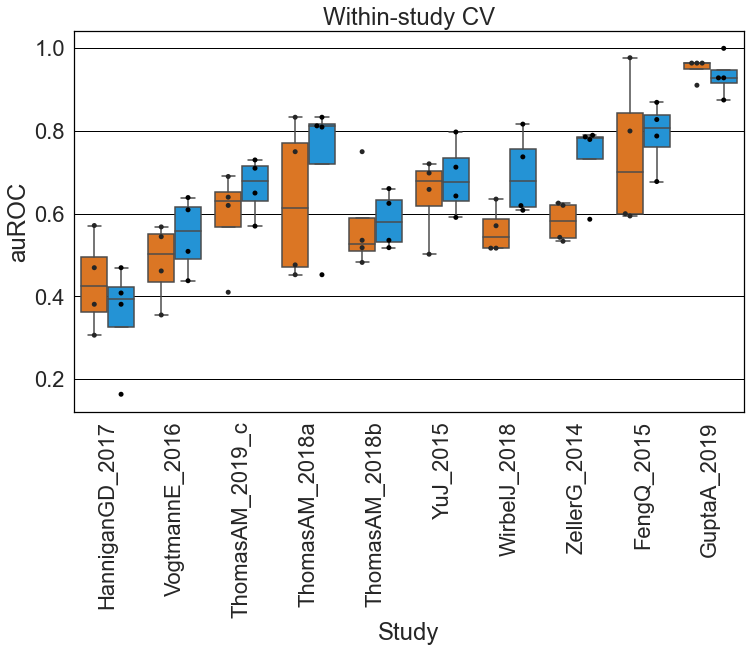

In [176]:
plt.figure(figsize=(12,7))
ax=sns.boxplot(x='Study', 
            y='auROC', 
            hue='Group', 
            data=results_df.loc[results_df.Study.isin(
                                    qq.loc[qq].index)
                                   ].sort_values('auROC'), 
            palette={'Raw':global_palette['linear'], 
                     'DEBIAS-M-Unibatch':global_palette['debias-m']}, 
            hue_order=['Raw', 'DEBIAS-M-Unibatch'], 
            fliersize=0
           )

sns.swarmplot(x='Study', 
              y='auROC', 
              hue='Group', 
              data=results_df.loc[results_df.Study.isin(
                                      qq.loc[qq].index)
                                     ].sort_values('auROC'), 
              color='black', 
              hue_order=['Raw', 'DEBIAS-M-Unibatch'], 
              s=5, 
              dodge=True
           )
ax.legend().remove()
plt.xticks(rotation=90)
plt.title('Within-study CV')
plt.show()

In [56]:
md_tmp=md.loc[md.Study==sd]
df_tmp=rescale(df.loc[md_tmp.index])

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [57]:
pprs = cross_val_score(LogisticRegression(penalty='none'), 
                        X=df_tmp, 
                        y=md_tmp.label.values, 
                        scoring='roc_auc', 
                        cv=StratifiedKFold()
                        )


In [59]:
pprs = cross_val_score(DebiasMunibClassifier(), 
                       X=df_tmp.values, 
                       y=md_tmp.label.values, 
                       scoring='roc_auc', 
                       cv=StratifiedKFold()
                       )

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

In [60]:
pprs

array([0.875     , 0.7       , 0.7       , 0.75      , 0.91111111])

In [58]:
pprs

array([0.775, 0.825, 0.725, 0.625, 0.6  ])

In [5]:
from sklearn.metrics import roc_auc_score

In [6]:
roc_auc_score(y, dmcu.predict_proba(X)[:, 1])

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.7049114331723028

In [7]:
import sys
sys.path.append('../../v2-final-debiasm-run/code/')
# sys.path.append('../../v2-final-debiasm-run/code/Cervix/')

In [9]:
# md.loc[md.carcinoma==1].Study.value_counts()

In [10]:
# md.Study.value_counts()

In [11]:
import run_cervix_analysis
run_cervix_analysis.task_mapping_dict

{'Cervix-CIN': <function run_cervix_analysis.CIN_func(md)>}

In [73]:
df = pd.read_csv('../../v2-final-debiasm-run/data/Cervix/data.csv', index_col=0)#.drop(['group', 'study'], axis=1)
md = pd.read_csv('../../v2-final-debiasm-run/data/Cervix/metadata.csv', index_col=0).loc[df.index]

md=run_cervix_analysis.task_mapping_dict['Cervix-CIN'](md)

# md=md.loc[md.Study=='Onywera']
# md=md.loc[md.Study=='Ilhan']
# md=md.loc[md.Study=='Audirac']
# md=md.loc[md.Study=='Ilhan']
# md=run_cervix_analysis.task_mapping_dict['Cervix-carcinoma'](md)
df=df.loc[md.index].round(5) ## adding this resolved discrepancies
                        ## between results on local machines
  

In [74]:
y = md.label==1

In [75]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression

In [76]:
cross_val_score(LogisticRegression(penalty='none', 
                                   max_iter=1000, 
                                   solver='newton-cg'), 
                X=rescale(df.values), 
                y=y, 
                scoring='roc_auc', 
                cv=StratifiedKFold()
#                 cv=5
                )

array([0.56407323, 0.5423341 , 0.3392435 , 0.54589372, 0.53743961])

In [79]:
cross_val_score(DebiasMunibClassifier(), 
                X=df.values, 
                y=y, 
                scoring='roc_auc', 
#                 cv=5
                cv=StratifiedKFold()
                )

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
GPU available: False, 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /Users/george/Desktop/DEBIAS-M-revisions/single-batch-cv/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax 

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([0.73455378, 0.67505721, 0.74940898, 0.40217391, 0.59903382])

In [124]:
df = pd.read_csv('../../v2-final-debiasm-run/data/Cervix/data.csv', index_col=0)#.drop(['group', 'study'], axis=1)
md = pd.read_csv('../../v2-final-debiasm-run/data/Cervix/metadata.csv', index_col=0).loc[df.index]

md=run_cervix_analysis.task_mapping_dict['Cervix-CIN'](md)
md=md.loc[md.Study==md.Study.value_counts().index.values[1]]
# md=md.loc[md.Study=='Onywera']
# md=md.loc[md.Study=='Ilhan']
# md=md.loc[md.Study=='Audirac']
# md=md.loc[md.Study=='Ilhan']
# md=run_cervix_analysis.task_mapping_dict['Cervix-carcinoma'](md)
df=df.loc[md.index].round(5)    
df=df.loc[:, (df>0).mean(axis=0)>0.05 ]
y=md.label.values

In [125]:
cross_val_score(LogisticRegression(penalty='none', 
                                   max_iter=1000, 
                                   solver='newton-cg'), 
                X=rescale(df.values), 
                y=y, 
                scoring='roc_auc', 
                cv=StratifiedKFold()
                )

array([0.55      , 0.45      , 0.52      , 0.33333333, 0.61111111])

In [126]:
cross_val_score(DebiasMunibClassifier(), 
                X=df.values, 
                y=y, 
                scoring='roc_auc', 
#                 cv=5
                cv=StratifiedKFold()
                )

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([0.55      , 0.65      , 0.56      , 0.57407407, 0.66666667])

In [104]:
df = pd.read_csv('../../v2-final-debiasm-run/data/CRC/data_relabund.csv', index_col=0)#.drop(['group', 'study'], axis=1)
md = pd.read_csv('../../v2-final-debiasm-run/data/CRC/metadata_relabund.csv', index_col=0).loc[df.index]

# md=md.loc[md.Study=='WirbelJ_2018']

md=md.loc[md.Study==md.Study.value_counts().index.values[0]]
df=df.loc[md.index]
df=df.loc[:, (df>0).mean(axis=0)>0.05 ]

y = md.label=='CRC'

In [105]:
np.random.seed(1)
torch.manual_seed(1)
cross_val_score(LogisticRegression(penalty='none', 
#                                    max_iter=1000, 
#                                    solver='newton-cg'
                                  ), 
                X=rescale(df.values), 
                y=y, 
                scoring='roc_auc', 
                cv=StratifiedKFold(n_splits=5)
#                 cv=5
                )

array([0.66060606, 0.60606061, 0.70909091, 0.61333333, 0.71428571])

In [106]:
# dmuc=DebiasMunibClassifier()
from sklearn.model_selection import StratifiedKFold

In [107]:
np.random.seed(1)
torch.manual_seed(1)
cross_val_score(DebiasMunibClassifier(l2_strength=0), 
                X=rescale(df.values), 
                y=y, 
                scoring='roc_auc', 
                cv=StratifiedKFold(n_splits=5)#5, 
                )

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

array([0.56363636, 0.70909091, 0.73939394, 0.74666667, 0.77922078])

In [66]:
df.shape

(125, 935)

In [63]:
roc_auc_score([1,0,0,0,1],
              [.05]*5
              )

0.5

In [36]:
pprs=cross_val_predict(#DebiasMunibClassifier(), 
                       LogisticRegression(penalty='none', 
                                   max_iter=1000, 
                                   solver='newton-cg'),
                X=rescale(df.values), 
                y=y, 
#                 scoring='roc_auc', 
                method='predict_proba',
                cv=5
                )

In [32]:
# pprs

In [38]:
roc_auc_score(y, pprs[:, 1])

0.6720512820512821

In [63]:
dmcu=DebiasMunibClassifier()
dmcu.fit(df.values, y)

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
GPU available: False, 

DebiasMunibClassifier()

In [65]:
roc_auc_score(y, dmcu.predict_proba(df.values)[:, 1] )

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.7656716417910449

In [142]:
df = pd.read_csv('../../New-vaginal-project/numom_preeclampsia/results/dataframes_for_corncob/micro_data.csv', 
           index_col=0)

md = pd.read_csv('../../New-vaginal-project/numom_preeclampsia/results/dataframes_for_corncob/metdata.csv', 
           index_col=0)

# df = df.loc[:, (df > 0).mean(axis=0)> 0.05]
y=md.PEC_case

In [143]:
roc_auc_score( 
    y,
    cross_val_predict(#DebiasMunibClassifier(), 
                       LogisticRegression(penalty='none', 
#                                    max_iter=1000, 
#                                    solver='newton-cg'
                                         ),
                X=rescale(df.values), 
                y=y, 
#                 scoring='roc_auc', 
#                 method='predict_proba',
                cv=RebalancedLeaveOneOut()
                )
    )

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

0.5705064548162859

In [137]:
from rebalancedleaveoneout import RebalancedLeaveOneOut

In [144]:
roc_auc_score( 
    y,
    cross_val_predict(DebiasMunibClassifier(), 
#                        LogisticRegression(penalty='none', 
# #                                    max_iter=1000, 
# #                                    solver='newton-cg'
#                                          ),
                X=rescale(df.values), 
                y=y, 
#                 scoring='roc_auc', 
#                 method='predict_proba',
                cv=RebalancedLeaveOneOut()
                )
    )

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar =

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/py

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar =

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_ra

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/py

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_cal

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_cal

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar =

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled t

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/py

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar =

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/py

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar =

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/py

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

0.5590863952333665

In [2]:
import pandas as pd

In [18]:
pd.read_csv('../data/CRC/PLSDAbatch_out.csv', index_col=0)

In [21]:
from debiasm.torch_functions import rescale

In [23]:
rescale( pd.read_csv('../data/CRC/MMUPHin_out.csv', index_col=0) ).isna().sum().sum()

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )


0

In [13]:
pd.read_csv('../data/CRC/percnorm_out.csv').isna().sum().sum()

266686

In [11]:
pd.read_csv('../data/HIVRC/percnorm_out.csv').isna().mean()

Unnamed: 0                                                0.00000
Acidaminococcus_fermentans                                0.03876
Acidaminococcus_intestinalis.Acidaminococcus_intestini    0.03876
Actinomyces_lingnae                                       0.03876
Actinomyces_odontolyticus                                 0.03876
                                                           ...   
merged.otu.Turicibacter_sanguinis                         0.03876
merged.otu.Vallitalea_guaymasensis                        0.03876
merged.otu.Vampirovibrio_chlorellavorus                   0.03876
merged.otu.Veillonella_dispar                             0.03876
merged.otu.Victivallis_vadensis                           0.03876
Length: 780, dtype: float64

In [136]:
cross_val_score(DebiasMunibClassifier(), 
#                        LogisticRegression(penalty='none', 
#                                    max_iter=1000, 
#                                    solver='newton-cg'),
                X=rescale(df.values), 
                y=y, 
                scoring='roc_auc', 
                
#                 method='predict_proba',
#                 cv=5
                )

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

array([0.25      , 0.85      , 0.65      , 0.61983471, 0.58333333])

In [591]:
md = pd.read_csv('../../SBCMP_analysis/CodeOcean_setup/data/cal_ptb/metadata.csv', 
                 index_col=0)

df = pd.read_csv('../../SBCMP_analysis/CodeOcean_setup/data/cal_ptb/data.csv', 
                 index_col=0)

md=md.loc[md.Study=='UAB_Callahan2017']
# md=md.loc[md.Study=='Blostein2020']
df=df.loc[md.index]

In [592]:
md.Study.value_counts()

UAB_Callahan2017    96
Name: Study, dtype: int64

In [594]:
df = rescale(df).loc[:, (df>0).mean(axis=0) > 0.05]

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [595]:
y = md.Preterm.values

In [596]:
seed=33
np.random.seed(seed)
torch.manual_seed(seed)
base=cross_val_score(LogisticRegression(penalty='none', 
                                   max_iter=100, 
                                   solver='newton-cg'
                                  ), 
                X=rescale(df.values), 
                y=y, 
                scoring='roc_auc', 
                cv=StratifiedKFold(n_splits=5, 
                                  shuffle=True, 
                                  random_state=seed)
#                 cv=5
                )
base

array([0.55555556, 0.63636364, 0.40909091, 0.56818182, 0.375     ])

In [597]:
seed=33
np.random.seed(seed)
torch.manual_seed(seed)
newb=cross_val_score(DebiasMunibClassifier(learning_rate=.5, 
                                           min_epochs=100), 
                X=rescale(df.values), 
                y=y, 
                scoring='roc_auc', 
                cv=StratifiedKFold(n_splits=5,
                                  shuffle=True, 
                                  random_state=seed)
                )
newb

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_co

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

array([0.77777778, 0.375     , 0.58522727, 0.70454545, 0.59090909])

In [598]:
base.mean()

0.5088383838383839

In [599]:
newb.mean()

0.6066919191919192

In [292]:
np.median(base)

0.40909090909090906

In [274]:
np.median(newb)

0.6363636363636364

In [241]:
# newb

In [242]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)
# pipe = Pipeline([('dmc', DebiasMunibClassifier()), 
#                  ('lr', LogisticRegressionCV(max_iter=1000))]
#                 )

pipe = Pipeline([('dmc', DebiasMunibClassifier()), 
                 ('lr', LogisticRegressionCV(max_iter=1000))]
                )

pipe.fit(X_train, y_train).score(X_test, y_test)
# pipe.set_params(svc__C=10).fit(X_train, y_train).score(X_test, y_test)

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

0.4583333333333333

In [600]:
pipe = Pipeline([
                 ('ss', StandardScaler()), 
                 ('lr', LogisticRegressionCV(max_iter=100,
                                             solver='newton-cg'))]
                )
seed=99
np.random.seed(seed)
torch.manual_seed(seed)
base=cross_val_score(pipe, 
                     X=rescale(df.values), 
                     y=y, 
                     scoring='roc_auc', 
                     cv=StratifiedKFold(n_splits=5, 
                                        shuffle=True,
                                        random_state=seed)
                     )
base

array([0.63636364, 0.59090909, 0.56818182, 0.48863636, 0.63636364])

In [601]:
from sklearn.preprocessing import StandardScaler

In [602]:
pipe = Pipeline([('dmc', DebiasMunibClassifier(learning_rate=.5, 
                                               min_epochs=100)), 
                 ('ss', StandardScaler()), 
                 ('lr', LogisticRegressionCV(max_iter=100, 
                                            solver='newton-cg'))
                ]
                 )

np.random.seed(seed)
torch.manual_seed(seed)
newb=cross_val_score(pipe, 
                     X=rescale(df.values), 
                     y=y, 
                     scoring='roc_auc', 
                     cv=StratifiedKFold(n_splits=5, 
                                        shuffle=True, 
                                        random_state=seed
                                        )
                     )
newb

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

array([0.60606061, 0.77272727, 0.76136364, 0.52272727, 0.69318182])

In [603]:
base.mean()

0.584090909090909

In [604]:
newb.mean()

0.6712121212121213

In [633]:
seed=0

In [634]:
pipe = Pipeline([
#     ('dmc', DebiasMunibClassifier(learning_rate=.5, 
#                                                min_epochs=100)), 
#                  ('ss', StandardScaler()), 
                 ('lr', LogisticRegressionCV(max_iter=100, 
                                            solver='newton-cg'))
                ]
                 )

np.random.seed(seed)
torch.manual_seed(seed)
base=cross_val_score(pipe, 
                     X=rescale(df.values), 
                     y=y, 
                     scoring='roc_auc', 
                     cv=StratifiedKFold(n_splits=5, 
                                        shuffle=True, 
                                        random_state=seed
                                        )
                     )
base

array([0.50505051, 0.31818182, 0.44318182, 0.5       , 0.69318182])

In [635]:
from sklearn.model_selection import GridSearchCV

parameters = {'w_l2':[0, 1e-6, 1e-4, 1e-2, 1],
              'l2_strength':[0, 1e-6, 1e-4, 1e-2, 1], 
              'learning_rate':[0.5]}

np.random.seed(seed)
torch.manual_seed(seed)

dmuc = DebiasMunibClassifier()
clf = GridSearchCV(dmuc, 
                   parameters, 
                   scoring='roc_auc'
                   )

newb=cross_val_score(clf, 
                     X=rescale(df.values), 
                     y=y, 
                     scoring='roc_auc', 
                     cv=StratifiedKFold(n_splits=5, 
                                        shuffle=True, 
                                        random_state=seed
                                        )
                     )
# newb


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68:

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled t

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled t

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/g

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/g

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68:

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled t

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the 

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled t

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68:

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68:

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/g

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minim

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/g

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/g

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68:

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/g

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68:

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/g

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68:

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled t

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68:

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68:

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/g

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68:

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68:

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minim

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minim

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/g

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/g

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled t

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68:

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callba

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68:

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68:

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/g

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Lightning

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_conn

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/g

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled t

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please conside

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [617]:
base

array([0.53535354, 0.36363636, 0.15909091, 0.36363636, 0.5       ])

In [610]:
newb

array([0.66666667, 0.70454545, 0.69318182, 0.45454545, 0.70454545])

In [615]:
base.mean()

0.584090909090909

In [611]:
newb.mean()

0.6446969696969698

In [643]:
base

array([0.50505051, 0.31818182, 0.44318182, 0.5       , 0.69318182])

In [642]:
newb

array([0.68686869, 0.60227273, 0.45454545, 0.75      , 0.56818182])

In [638]:
base.mean()

0.49191919191919187

In [641]:
newb.mean()

0.6123737373737373

In [645]:
results_df = pd.DataFrame({#'Study':flatten(cv_study) + flatten(cv_study), 
                           'Group':['Raw']*5 + \
                                   ['DEBIAS-M-Unibatch']*len(list(newb)),
                           'auROC':list(base)+list(newb)
                           })

In [650]:
import matplotlib.pyplot as plt
import seaborn as sns
from General_functions.plotting import global_palette

In [652]:
results_df

Group     auROC
0                Raw  0.505051
1                Raw  0.318182
2                Raw  0.443182
3                Raw  0.500000
4                Raw  0.693182
5  DEBIAS-M-Unibatch  0.686869
6  DEBIAS-M-Unibatch  0.602273
7  DEBIAS-M-Unibatch  0.454545
8  DEBIAS-M-Unibatch  0.750000
9  DEBIAS-M-Unibatch  0.568182

In [654]:
global_palette

{'linear': '#F97306',
 'debias-m': '#069AF3',
 'conqur': 'red',
 'combat': '#15B01A',
 'snm': 'pink',
 'mmuphin': 'brown',
 'plsda': 'gold',
 'percnorm': 'purple'}

In [660]:
results_df

Group     auROC
0                Raw  0.505051
1                Raw  0.318182
2                Raw  0.443182
3                Raw  0.500000
4                Raw  0.693182
5  DEBIAS-M-Unibatch  0.686869
6  DEBIAS-M-Unibatch  0.602273
7  DEBIAS-M-Unibatch  0.454545
8  DEBIAS-M-Unibatch  0.750000
9  DEBIAS-M-Unibatch  0.568182

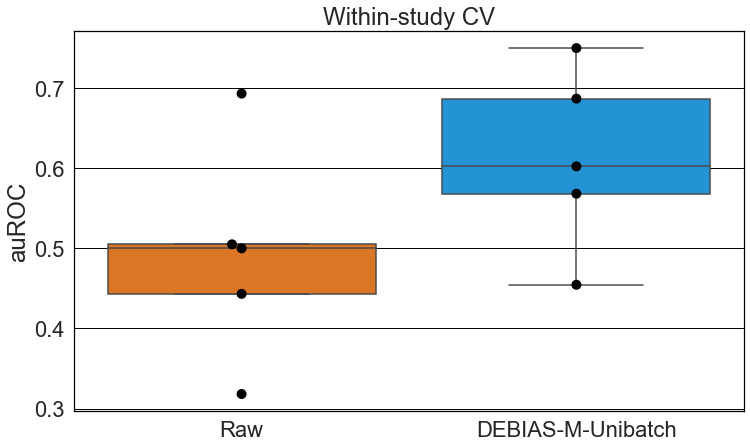

In [668]:
plt.figure(figsize=(12,7))
ax=sns.boxplot(
            x='Group', 
            y='auROC', 
#             hue='Group', 
            data=results_df, 
            palette={'Raw':global_palette['linear'], 
                     'DEBIAS-M-Unibatch':global_palette['debias-m']}, 
            order=['Raw', 'DEBIAS-M-Unibatch'], 
            fliersize=0
           )

sns.swarmplot(
#     x/Study', 
              y='auROC', 
              x='Group', 
              data=results_df, 
              color='black', 
              hue_order=['Raw', 'DEBIAS-M-Unibatch'], 
              s=10, 
              dodge=True
           )
# ax.legend().remove()
# plt.xticks(rotation=90)
plt.xlabel(None)
plt.title('Within-study CV')
plt.show()

In [691]:
rf_params = {'max_depth':[5, 10], 
              'n_estimators':[500],
              'min_samples_split':[.5, .75, .9]
             }


clf = GridSearchCV(RandomForestClassifier(), 
                   rf_params, 
                   scoring='roc_auc'
                   )
pipe = Pipeline([
#     ('dmc', DebiasMunibClassifier(learning_rate=.5, 
#                                                min_epochs=100)), 
#                  ('ss', StandardScaler()), 
                 ('lr', clf )
                ]
                 )

np.random.seed(seed)
torch.manual_seed(seed)
rf_base=cross_val_score(pipe, 
                     X=rescale(df.values), 
                     y=y, 
                     scoring='roc_auc', 
                     cv=StratifiedKFold(n_splits=5, 
                                        shuffle=True, 
                                        random_state=seed
                                        )
                     )
rf_base

array([0.6969697 , 0.77272727, 0.61363636, 0.71590909, 0.71590909])

In [682]:
from sklearn.pipeline import make_pipeline

In [684]:
print('runnning')

runnning


In [697]:
# from sklearn.model_selection import GridSearchCV

parameters = {'w_l2':[0, 1e-6, 1e-4, 1e-2, 1],
              'l2_strength':[0, 1e-6, 1e-4, 1e-2, 1], 
              'learning_rate':[0.5], 
              'min_epochs':[100]
              }

np.random.seed(seed)
torch.manual_seed(seed)

# dmuc = DebiasMunibClassifier()
clf_db = GridSearchCV(dmuc, 
                   parameters, 
                   scoring='roc_auc'
                   )

# clf_ = make_pipeline(clf, 
#                     RandomForestClassifier())
pipe = Pipeline([
    ('dmc', clf_db ),
                 ('lr', clf )
                ]
                 )


rf_newb=cross_val_score(pipe, 
                     X=rescale(df.values), 
                     y=y, 
                     scoring='roc_auc', 
                     cv=StratifiedKFold(n_splits=5, 
                                        shuffle=True, 
                                        random_state=seed
                                        )
                     )

rf_newb

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be remove

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: Ligh

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated i

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated i

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_co

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signal

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signal

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signal

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or mi

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signal

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or mi

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or mi

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signal

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signal

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or mi

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or mi

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signal

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in t

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/U

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/U

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be remove

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or mi

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or mi

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signal

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signal

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signal

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or mi

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or mi

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please con

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or mi

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signal

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signal

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (100) or minimum steps (No

array([0.74747475, 0.82954545, 0.57954545, 0.52840909, 0.70454545])

In [698]:
results_df2 = pd.DataFrame({#'Study':flatten(cv_study) + flatten(cv_study), 
                           'Group':['Random Forest']*5 + \
                                   ['DEBIAS-M-Unibatch --> RF']*len(list(rf_newb)),
                           'auROC':list(rf_base)+list(rf_newb)
                           })

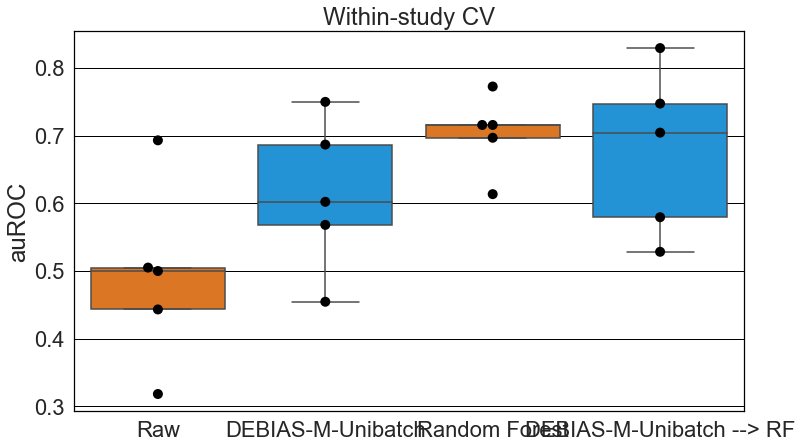

In [699]:
rrr=pd.concat([results_df, results_df2]).reset_index(drop=True)

plt.figure(figsize=(12,7))
ax=sns.boxplot(
            x='Group', 
            y='auROC', 
#             hue='Group', 
            data=rrr, 
            palette={'Raw':global_palette['linear'], 
                     'DEBIAS-M-Unibatch':global_palette['debias-m'], 
                     'Random Forest':global_palette['linear'],
                    'DEBIAS-M-Unibatch --> RF':global_palette['debias-m'], 
                    }, 
            order=[
                  'Raw', 'DEBIAS-M-Unibatch', 
                         'Random Forest', 'DEBIAS-M-Unibatch --> RF'], 
            fliersize=0
           )

sns.swarmplot(
#     x/Study', 
              y='auROC', 
              x='Group', 
              data=rrr, 
              color='black', 
              hue_order=['Raw', 'DEBIAS-M-Unibatch', 
                         'Random Forest', 'DEBIAS-M-Unibatch --> RF'], 
              s=10, 
              dodge=True
           )
# ax.legend().remove()
# plt.xticks(rotation=90)
plt.xlabel(None)
plt.title('Within-study CV')
plt.show()

In [672]:
pd.read_csv('../results/Cervix-carcinoma/linear-benchmark-prs.csv').Group.unique()

array(['Raw (no correction) (auPR = 0.54)', 'DEBIAS-M (auPR = 0.72)',
       'ComBat (auPR = 0.38)', 'ConQuR (auPR = 0.40)',
       'Voom-SNM (auPR = 0.23)', 'MMUPHin (auPR = 0.62)',
       'PLSDAbatch (auPR = 0.41)',
       'Percentile normalization (auPR = 0.36)'], dtype=object)

In [15]:
md.Study.value_counts()

Elovitz2019         539
Tabatabaei2019      449
Blostein2020        125
UAB_Callahan2017     96
Digiulio2015         40
ST_Callahan2017      39
Subramaniam2018      38
Name: Study, dtype: int64

In [295]:
from sklearn.ensemble import RandomForestClassifier

In [590]:
pipe = Pipeline([
                 ('ss', StandardScaler()), 
                 ('lr', RandomForestClassifier(
#                      n_estimators=100, 
#                                                max_depth=7
                 ))]
                )

seed=222
np.random.seed(seed)
torch.manual_seed(seed)
base=cross_val_score(pipe, 
                     X=rescale(df.values), 
                     y=y, 
                     scoring='roc_auc', 
                     cv=StratifiedKFold(n_splits=5, 
                                       shuffle=True, 
                                       random_state=seed)
                     )
base

array([0.77777778, 0.60227273, 0.76704545, 0.64772727, 0.63636364])

In [577]:
pipe = Pipeline([('dmc', DebiasMunibClassifier(learning_rate=.1, 
                                               min_epochs=100)), 
                 ('ss', StandardScaler()), 
                 ('lr', RandomForestClassifier(
#                      n_estimators=100, 
#                                                max_depth=7
                                              ))
                ]
                 )

seed=222
np.random.seed(seed)
torch.manual_seed(seed)
# np.random.seed(99)
# torch.manual_seed(99)
newb=cross_val_score(pipe, 
                     X=rescale(df.values), 
                     y=y, 
                     scoring='roc_auc', 
                     cv=StratifiedKFold(n_splits=5, 
                                       shuffle=True, 
                                       random_state=seed)
                     )
newb

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/U

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `nu

array([0.72727273, 0.84659091, 0.89204545, 0.71022727, 0.48863636])

In [580]:
base.mean()

0.6862373737373739

In [578]:
newb.mean()

0.7329545454545454

In [ ]:
run_cervix_analysis.lo